In [2]:
import pennylane.numpy as np

import matplotlib.pyplot as plt

In [3]:
### Uniform Sampling
def uniform_sampling(x_init, x_final, n_samples):
    return  np.random.uniform(x_init, x_final, size = n_samples)

### Importance Sampling
def p(test_func, x):
    fx = test_func(x)
    dfdx = np.gradient(fx, x)                                
    return dfdx**2                                  # Target function to distribution like...

def q(x, x_init, x_final):                          # Proposal distribution
    return np.ones_like(x) / (x_final - x_init)     # Uniform

def importance_sampling(test_func, x_init, x_final, n_samples):
    # Sample from q(x)
    N = 100000
    x_samples = np.random.uniform(x_init, x_final, size = N)

    # Wetight
    w = p(test_func, x_samples) / q(x_samples, x_init, x_final)
    w /= np.sum(w)

    # Resample according to weights
    resampled_indices = np.random.choice(np.arange(N), size = n_samples, p = w)
    x_resampled = x_samples[resampled_indices]

    return np.array(x_resampled)

### Hamiltonian Monte Carlo(HMC)
def U(test_func, x):
    fx = test_func(x)
    return -np.log(np.abs(fx) + 1e-10)

def grad_U(test_func, x, h=1e-5):
    return (U(test_func, x + h) - U(test_func, x - h)) / (2*h)

def leapfrog(test_func, x, p, step_size, n_steps):
    x_new = x
    p_new = p - 0.5 * step_size * grad_U(test_func, x_new)
    for _ in range(n_steps):
        x_new = x_new + step_size * p_new
        if _ != n_steps - 1:
            p_new = p_new - step_size * grad_U(test_func, x_new)
    p_new = p_new - 0.5 * step_size * grad_U(test_func, x_new)
    return x_new, p_new

def hamiltonian_monte_carlo(test_func, x_init, x_final, step_size=0.1, n_steps=20, n_samples=1000):
    samples = []
    x = (x_init + x_final) / 2
    for _ in range(n_samples):
        p = np.random.normal()
        current_H = U(test_func, x) + 0.5 * p**2
        x_new, p_new = leapfrog(test_func, x, p, step_size, n_steps)

        # Reject if x_new is out of bounds
        if x_new < x_init or x_new > x_final:
            samples.append(x)  # reject, keep current x
            continue

        proposed_H = U(test_func, x_new) + 0.5 * p_new**2
        accept_prob = np.exp(current_H - proposed_H)
        if np.random.rand() < accept_prob:
            x = x_new  # Accept
        samples.append(x)
    return np.array(samples)

In [4]:
class Data_Sampling:
    def __init__(self, sample_type, n_samples):
        self.sample_type = sample_type
        self.n_samples = int(n_samples)
    
    def data_sampling(self, test_func, x_init, x_final):
        if self.sample_type == 'Uni':
            x = uniform_sampling(x_init, x_final, self.n_samples)
        
        elif self.sample_type == 'Imp':
            x = importance_sampling(test_func,  x_init, x_final, self.n_samples)
        
        elif self.sample_type == 'HMC':
            x_hmc = hamiltonian_monte_carlo(test_func,  x_init, x_final, step_size = 0.1, n_steps = 20, n_samples = int(self.n_samples / 2))
            x_uni = uniform_sampling(x_init, x_final, int(self.n_samples / 2))
            x = np.concatenate((x_hmc, x_uni))

        return x

In [5]:
### Test function
def Complex_Phase_function(x):
    return np.cos(x + 0.5*np.sin(4*x))

def Step_function(x, x_0 = 0):
    return np.heaviside(x, x_0) - 0.5

def Breit_Wigner_Distribution(x, M = 91.18, Gamma = 2.49):
    k = 1
    val = (x**2 - M**2)**2 + M**2 * Gamma**2
    return  k / val

-----

(array([ 181.,  155.,  199.,  262.,  868., 2379.,  330.,  257.,  210.,
         159.]),
 array([ 60.00954298,  66.00460767,  71.99967235,  77.99473704,
         83.98980172,  89.98486641,  95.97993109, 101.97499578,
        107.97006046, 113.96512515, 119.96018984]),
 <BarContainer object of 10 artists>)

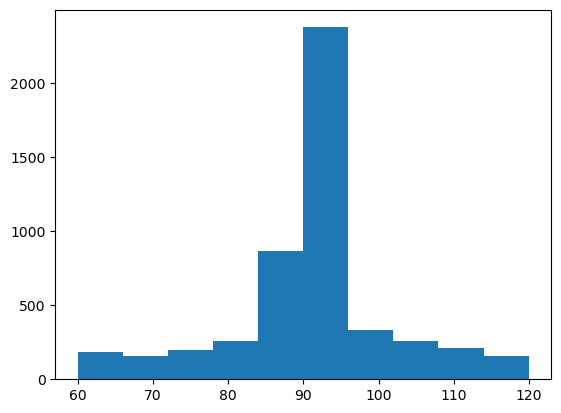

In [ ]:
sample_type = 'Imp'         # TODO : Uni / Imp / HMC
n_samples = '5000'          # TODO : The number of sample points
x_init, x_final = 60, 120   # TODO : Setting The Range for the target function

Data_generator = Data_Sampling(sample_type, n_samples)
x = Data_generator.data_sampling(Breit_Wigner_Distribution, x_init, x_final)
y = Breit_Wigner_Distribution(x)

#np.savez(f"./Data File/Training/BW_Data({sample_type}, {n_samples}).npz", x_init = x_init, x_final = x_final, x_data = x, y_data = y)

plt.hist(x)

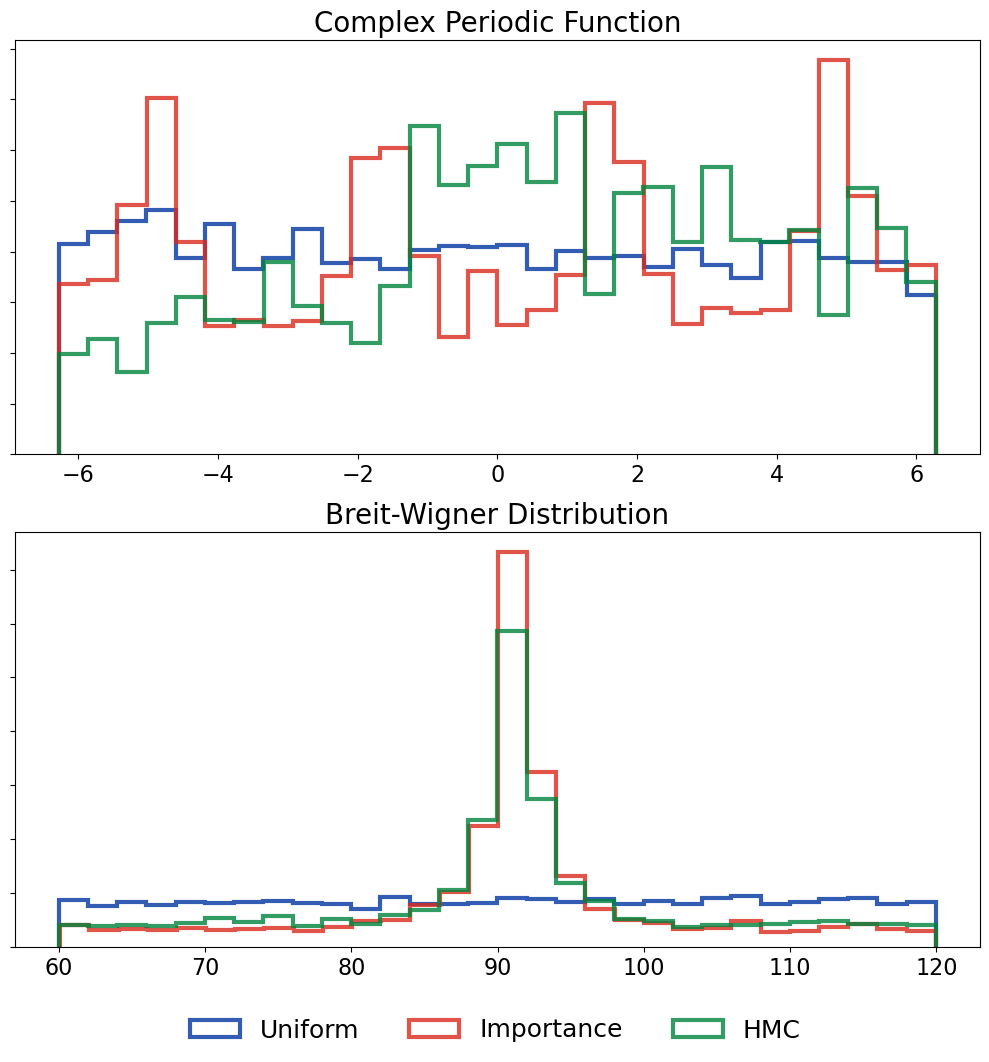

In [41]:
plt.rcParams.update({
    "axes.labelsize" : 18,
    "xtick.labelsize" : 16,
    "ytick.labelsize" : 16,
    "legend.fontsize" : 18,
    "axes.titlesize" : 20
})

n_samples = '5000'          # TODO : The number of sample points

uni_generator = Data_Sampling('Uni', n_samples)
imp_generator = Data_Sampling('Imp', n_samples)
hmc_generator = Data_Sampling('HMC', n_samples)


fig, (ax1, ax2) = plt.subplots(2,1, figsize = (10, 10))

# 색상 정의 (CMS 스타일)
colors = {
    "Uni": "#0033A0",    # CMS Blue
    "Imp": "#DA291C", # CMS Red
    "HMC": "#00843D"         # CMS Green
}

x_uni = uni_generator.data_sampling(Complex_Phase_function, -2*np.pi, 2*np.pi)
x_imp = imp_generator.data_sampling(Complex_Phase_function, -2*np.pi, 2*np.pi)
x_hmc = hmc_generator.data_sampling(Complex_Phase_function, -2*np.pi, 2*np.pi)

# 히스토그램 그리기 (투명도와 선 스타일 활용)
ax1.hist(x_uni, bins=30, color=colors["Uni"], linestyle = '-', linewidth = 3, label="Uniform", histtype='step', alpha = 0.8,  density = True)
ax1.hist(x_imp, bins=30, color=colors["Imp"], linestyle = '-', linewidth = 3, label="Importance", histtype='step', alpha = 0.8, density = True)
ax1.hist(x_hmc, bins=30, color=colors["HMC"], linestyle = '-', linewidth = 3, label="HMC", histtype='step',  alpha = 0.8, density = True)

# 라벨 및 범례
#ax.set_xlabel(r"$x$")
ax1.set_title("Complex Periodic Function")
ax1.set_yticklabels([])
ax1.tick_params(axis='both')

x_uni = uni_generator.data_sampling(Breit_Wigner_Distribution, 60, 120)
x_imp = imp_generator.data_sampling(Breit_Wigner_Distribution, 60, 120)
x_hmc = hmc_generator.data_sampling(Breit_Wigner_Distribution, 60, 120)

ax2.hist(x_uni, bins=30, color=colors["Uni"], linestyle = '-', linewidth = 3, label="Uniform", histtype='step', alpha = 0.8,  density = True)
ax2.hist(x_imp, bins=30, color=colors["Imp"], linestyle = '-', linewidth = 3, label="Importance", histtype='step', alpha = 0.8, density = True)
ax2.hist(x_hmc, bins=30, color=colors["HMC"], linestyle = '-', linewidth = 3, label="HMC", histtype='step',  alpha = 0.8, density = True)

ax2.set_title("Breit-Wigner Distribution")
ax2.set_yticklabels([])
ax2.tick_params(axis='both')

handles, labels = ax1.get_legend_handles_labels()

fig.tight_layout()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.07))

plt.savefig("Sampling.pdf", dpi =300, bbox_inches = 'tight')
plt.show()

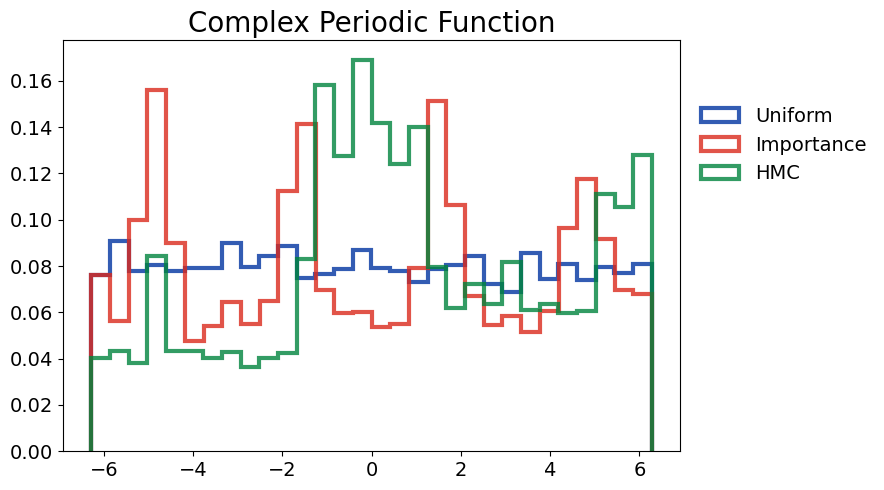

In [ ]:
plt.rcParams.update({
    "axes.labelsize" : 18,
    "xtick.labelsize" : 16,
    "ytick.labelsize" : 16,
    "legend.fontsize" : 16,
    "axes.titlesize" : 20
})

n_samples = '5000'          # TODO : The number of sample points

uni_generator = Data_Sampling('Uni', n_samples)
imp_generator = Data_Sampling('Imp', n_samples)
hmc_generator = Data_Sampling('HMC', n_samples)

x_uni = uni_generator.data_sampling(Complex_Phase_function, -2*np.pi, 2*np.pi)
x_imp = imp_generator.data_sampling(Complex_Phase_function, -2*np.pi, 2*np.pi)
x_hmc = hmc_generator.data_sampling(Complex_Phase_function, -2*np.pi, 2*np.pi)

fig, ax = plt.subplots(1,1, figsize = (7, 5))

# 색상 정의 (CMS 스타일)
colors = {
    "Uni": "#0033A0",    # CMS Blue
    "Imp": "#DA291C", # CMS Red
    "HMC": "#00843D"         # CMS Green
}



# 히스토그램 그리기 (투명도와 선 스타일 활용)
ax.hist(x_uni, bins=30, color=colors["Uni"], linestyle = '-', linewidth = 3, label="Uniform", histtype='step', alpha = 0.8,  density = True)
ax.hist(x_imp, bins=30, color=colors["Imp"], linestyle = '-', linewidth = 3, label="Importance", histtype='step', alpha = 0.8, density = True)
ax.hist(x_hmc, bins=30, color=colors["HMC"], linestyle = '-', linewidth = 3, label="HMC", histtype='step',  alpha = 0.8, density = True)

# 라벨 및 범례
#ax.set_xlabel(r"$x$")
ax.set_title("Complex Periodic Function")
handles, labels = ax.get_legend_handles_labels()

fig.tight_layout()
fig.legend(handles, labels, loc='right', ncol=1, frameon=False, bbox_to_anchor=(1.27, 0.7))


plt.savefig("Sampling_CPF.pdf", dpi =300, bbox_inches = 'tight')
plt.show()


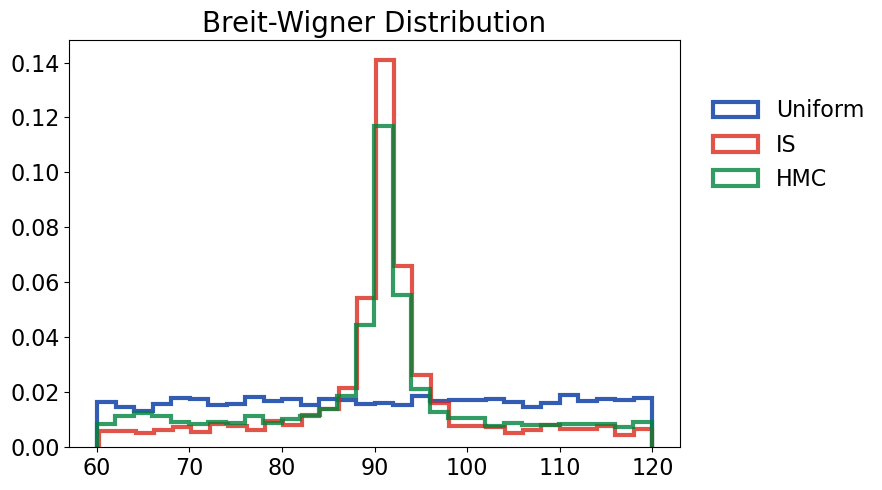

In [ ]:
plt.rcParams.update({
    "axes.labelsize" : 18,
    "xtick.labelsize" : 16,
    "ytick.labelsize" : 16,
    "legend.fontsize" : 16,
    "axes.titlesize" : 20
})

n_samples = '5000'          # TODO : The number of sample points

uni_generator = Data_Sampling('Uni', n_samples)
imp_generator = Data_Sampling('Imp', n_samples)
hmc_generator = Data_Sampling('HMC', n_samples)

x_uni = uni_generator.data_sampling(Breit_Wigner_Distribution, 60, 120)
x_imp = imp_generator.data_sampling(Breit_Wigner_Distribution, 60, 120)
x_hmc = hmc_generator.data_sampling(Breit_Wigner_Distribution, 60, 120)

fig, ax = plt.subplots(1,1, figsize = (7, 5))

# 색상 정의 (CMS 스타일)
colors = {
    "Uni": "#0033A0",    # CMS Blue
    "Imp": "#DA291C", # CMS Red
    "HMC": "#00843D"         # CMS Green
}


# 히스토그램 그리기 (투명도와 선 스타일 활용)
ax.hist(x_uni, bins=30, color=colors["Uni"], linestyle = '-', linewidth = 3, label="Uniform", histtype='step', alpha = 0.8,  density = True)
ax.hist(x_imp, bins=30, color=colors["Imp"], linestyle = '-', linewidth = 3, label="IS", histtype='step', alpha = 0.8, density = True)
ax.hist(x_hmc, bins=30, color=colors["HMC"], linestyle = '-', linewidth = 3, label="HMC", histtype='step',  alpha = 0.8, density = True)

# 라벨 및 범례
#ax.set_xlabel(r"$x$")
ax.set_title("Breit-Wigner Distribution")
handles, labels = ax.get_legend_handles_labels()

fig.tight_layout()
fig.legend(handles, labels, loc='right', ncol=1, frameon=False, bbox_to_anchor=(1.27, 0.7))


plt.savefig("Sampling_BW.pdf", dpi =300, bbox_inches = 'tight')
plt.show()


------